This script implements a gradient-based frame interpolation algorithm for fusing event streams with intensity frames

No residual learning is applied

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys, inspect
import numpy as np
import datetime, time
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
from skimage.io import imread
from skimage.io import imsave
import utils.visualization as vs
import utils.events_processing as ep
from utils.tensorflowvgg import vgg19
import json

In [2]:
VGG_MEAN = [103.939, 116.779, 123.68]
class custom_Vgg19(vgg19.Vgg19):
    # Input should be an rgb image [batch, height, width, 3]
    # values scaled [0, 1]

    def __init__(self, rgb, vgg19_npy_path, train=False):
        # It's a shared weights data and used in various
        # member functions.
        if vgg19_npy_path is None:
            path = inspect.getfile(Vgg19)
            path = os.path.abspath(os.path.join(path, os.pardir))
            path = os.path.join(path, "vgg19.npy")
            vgg19_npy_path = path
            print(vgg19_npy_path)

        self.data_dict = np.load(vgg19_npy_path, encoding='latin1').item()
        print("npy file loaded")

        start_time = time.time()

        # rgb_scaled = rgb * 255.0
        rgb_scaled = rgb
        # Convert RGB to BGR
        red, green, blue = tf.split(rgb_scaled, 3, 3)

        bgr = tf.concat([blue - VGG_MEAN[0],
                        green - VGG_MEAN[1],
                        red - VGG_MEAN[2]],
                        3)

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self.max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.pool5 = self.max_pool(self.conv5_3, 'pool5')

        # self.data_dict = None
        print ("build model finished: %ds" % (time.time() - start_time))

    def debug(self):
        pass

In [2]:
# load data (color frames and events)
dataDir = '/home/winston/git/int-event-fusion/sample_preparation/adobe-test'
vidList = os.listdir(dataDir)
vidId = 3
clipDir = os.path.join(dataDir, vidList[vidId], 'clip')
evfDir = os.path.join(dataDir, vidList[vidId], 'event-frames')
startFrameId = 0
endFrameId = 2
vid_gt = np.array([imread(os.path.join(clipDir, '%02d.png' % i)) for i in range(startFrameId, endFrameId+1)])/255.0
print("Finished reading video 'vid_gt', with shape", np.shape(vid_gt), "max_val:", np.max(vid_gt))
evf_gt = (np.array([imread(os.path.join(evfDir, '%02d.png' % i)) for i in range(startFrameId, endFrameId)])/255.0 - 0.5)*2
print("Finished reading event frames 'evf_gt', with shape", np.shape(evf_gt), "max_val", np.max(evf_gt), "min_val", np.min(evf_gt))
lres_gt = np.array([vid_gt[0], vid_gt[-1]])
print("Finished creating 'lres_gt', with shape", np.shape(lres_gt))

Finished reading video 'vid_gt', with shape (3, 500, 500, 3) max_val: 1.0
Finished reading event frames 'evf_gt', with shape (2, 500, 500, 3) max_val 1.0 min_val -1.0
Finished creating 'lres_gt', with shape (2, 500, 500, 3)


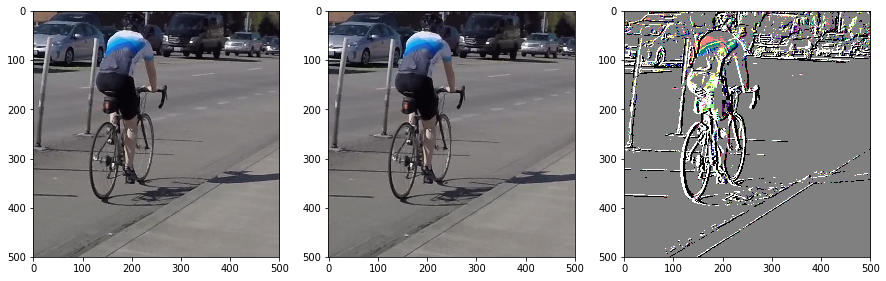

In [3]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(lres_gt[0])
plt.subplot(132)
plt.imshow(lres_gt[1])
plt.subplot(133)
plt.imshow((evf_gt[0]+1)/2.0)

In [4]:
# models
def init_hres(config, lres_gt):
    # input lres_gt should be in shape (t, y, x, c)
    lres_mean = np.expand_dims(np.mean(lres_gt, axis = 0), axis = 0)
    #print("shape of 'lres_mean'", np.shape(lres_mean))
    # (1, y, x, c)
    lres_start = tf.Variable(np.expand_dims(lres_gt[0], axis = 0), dtype = tf.float32)
    lres_end = tf.Variable(np.expand_dims(lres_gt[1], axis = 0), dtype = tf.float32)
    # init hres
    if config.init_mode == 0: # hres init as lres_0-lres_mean-lres_1
        for i in range(config.dim_hrt):
            if i == 0:
                hres_init = lres_start
            elif i == config.dim_hrt - 1:
                hres_init = tf.concat([hres_init, tf.Variable(lres_end, dtype = tf.float32)], 0)
            else:
                hres_init = tf.concat([hres_init, tf.Variable(lres_mean_var, dtype = tf.float32)], 0)
        print("hres_tensor initialized (lres-mean-lres)")
    elif config.init_mode == 1: # hres init as mean+rand
        for i in range(config.dim_hrt):
            lres_rand = lres_mean*(1.0 - config.noise_a) + config.noise_a*(np.random.rand(1, config.dim_y, config.dim_x, config.dim_c)-0.5)
            if i == 0:
                hres_init = lres_start
            elif i == config.dim_hrt - 1:
                hres_init = tf.concat([hres_init, lres_end], 0)
            else:
                hres_init = tf.concat([hres_init, tf.Variable(lres_rand, dtype = tf.float32)], 0)
        print("hres_tensor initialized (rand)")
    elif config.init_mode == 2: # a* lres_start + (1-a)*lres_end
        for i in range(config.dim_hrt):
            a = i / (config.dim_hrt - 1)
            if i == 0:
                hres_init = lres_start
            else:
                frame = (1-a)*lres_start + a*lres_end
                hres_init = tf.concat([hres_init, tf.Variable(frame, dtype = tf.float32)], 0)
    hres_init = tf.expand_dims(hres_init, axis = 0)
    print("hres_init shape:", np.shape(hres_init))
    return hres_init
    
def init_flow(config):
    if config.flow_init == 0:
        flow_x = tf.Variable(tf.zeros(config.hres_dim))
        flow_y = tf.Variable(tf.zeros(config.hres_dim))
        flow = tf.concat([flow_x, flow_y], 0)
        return flow
        
def frame_model(config, hres_tensor):
    if config.shape_mode <=1: #  interpolation
        # hres_tensor in shape (t, y, x, c)
        lres_tensor = tf.transpose(tf.gather_nd(tf.transpose(hres_tensor, perm = [1,2,3,4,0]), 
                                                indices = [[0],[config.dim_hrt-1]]), 
                                   perm = [4,0,1,2,3])
        print("lres_tensor, shape:", np.shape(lres_tensor))
    return lres_tensor

def event_model(config, hres_tensor):
    hres_relu = tf.nn.relu(hres_tensor)
    tanh_coef = tf.constant(config.tanh_coef)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    k_tyx = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 1), axis = 2), axis = 3)
    k_tyxi = tf.expand_dims(tf.concat([k_tyx, k_tyx, k_tyx], axis = 3), axis = 4)
    k_tyxio = tf.concat([k_tyxi, k_tyxi, k_tyxi], axis = 4)
    #print("shape of 'hres_ndhwc':", np.shape(hres_ndhwc))
    #print("shape of 'k_tyxio':", np.shape(k_tyxio))
    evf_tanh = tf.tanh(tanh_coef*tf.nn.convolution(input = hres_relu, filter = k_tyxio, padding = "VALID", data_format = "NDHWC"))
    print("evf_tanh, shape:", np.shape(evf_tanh))
    if config.shape_mode == 0:
        evf_tanh = tf.reduce_sum(evf_tanh, 1, keepdims = True)
    return evf_tanh

def tv_2d(config, hres_tensor):
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 0), axis = 2), axis = 3)
    kxi = tf.expand_dims(tf.concat([kx, kx, kx], axis = 3), axis = 4)
    kxio = tf.concat([kxi, kxi, kxi], axis = 4)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 1), axis = 2), axis = 3)
    kyi = tf.expand_dims(tf.concat([ky, ky, ky], axis = 3), axis = 4)
    kyio = tf.concat([kyi, kyi, kyi], axis = 4)
    
    dx = tf.nn.convolution(input = hres_tensor, filter = kxio, padding = "SAME", data_format = "NDHWC")
    dy = tf.nn.convolution(input = hres_tensor, filter = kyio, padding = "SAME", data_format = "NDHWC")
    return tf.norm(dx+dy, ord = 1)

def tv_t(config, hres_tensor):
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 0), axis = 0), axis = 3)
    kti = tf.expand_dims(tf.concat([kt, kt, kt], axis = 3), axis = 4)
    ktio = tf.concat([kti, kti, kti], axis = 4)
    dt = tf.nn.convolution(input = hres_tensor, filter = ktio, padding = "VALID", data_format = "NDHWC")
    return tf.norm(dt, ord = 1)

def flow_loss(config, hres_tensor, flow):
    flowx_tensor = tf.slice(flow, [0,0,0,0],[1,-1,-1,-1])
    flowy_tensor = tf.slice(flow, [1,0,0,0],[1,-1,-1,-1])
    hres_ndhwc = tf.expand_dims(hres_tensor, axis = 4)
    flowx_ndhwc = tf.expand_dims(flowx_tensor, axis = 4)
    flowy_ndhwc = tf.expand_dims(flowy_tensor, axis = 4)
    
    flow_coef_xy = tf.constant(config.flow_norm_xy_coef, dtype = tf.float32)
    flow_coef_t = tf.constant(config.flow_norm_t_coef, dtype = tf.float32)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 1), axis = 2), axis = 3), axis = 4)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 0), axis = 2), axis = 3), axis = 4)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 0), axis = 0), axis = 3), axis = 4)
    
    dHx = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dHy = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dHt = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    
    flow_eq = tf.multiply(dHx, flowx_tensor) + tf.multiply(dHy, flowy_tensor) + dHt
    
    dUxx = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dUxy = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dUyx = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dUyy = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dUxt = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    dUyt = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    
    return tf.norm(flow_eq, ord = 1) + flow_coef_xy*tf.norm(dUxx+dUxy+dUyx+dUyy, ord = 1)+ flow_coef_t*tf.norm(dUxt+dUyt, ord = 1)


def loss_all(config, ph, hres_tensor, lres_tensor, evf_tensor, flow_tensor):
    # frame_loss = tf.reduce_mean(tf.squared_difference(ph.lres_gt, lres_tensor))
    # event_loss = tf.constant(config.ev_weight)*tf.reduce_mean(tf.squared_difference(ph.evf_gt, evf_tensor))
    frame_loss = tf.norm(ph.lres_gt - lres_tensor, ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - evf_tensor, ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    opt_flow_loss = tf.constant(config.flow_loss_coef)*flow_loss(config, hres_tensor, flow_tensor)
    return frame_loss + event_loss + tv_loss + opt_flow_loss

def loss_pix_tv(config, ph, hres_tensor, lres_tensor, evf_tensor):
    frame_loss = tf.norm(ph.lres_gt - tf.squeeze(lres_tensor, [0]), ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - tf.squeeze(evf_tensor, [0]), ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    return frame_loss + event_loss + tv_loss

In [103]:
# config
class config():
    def __init__(self, hres_dim = None, evf_dim = None, shape_mode = 0, init_mode = 0):
        self.shape_mode = shape_mode
        self.init_mode = init_mode
                
        if self.shape_mode == 0: # interpolation mode, lres is {start + end} frame of hres, evf is 1-frame
            self.hres_dim = hres_dim
            (self.dim_hrt, self.dim_y, self.dim_x, self.dim_c) = hres_dim
            self.lres_dim = (2, self.dim_y, self.dim_x, self.dim_c)
            self.evf_dim = (self.dim_hrt - 1, self.dim_y, self.dim_x, self.dim_c)
        elif self.shape_mode == 1: # interpolation mode, lres same as mode 0, evf will be defined
            self.evf_dim = evf_dim
            (self.dim_evt, self.dim_y, self.dim_x, self.dim_c) = evf_dim
            self.lres_dim = (2, self.dim_y, self.dim_x, self.dim_c)
            
            self.dim_hrt = self.dim_evt + 1
            
        if self.init_mode == 1: # random initialization of hres_tensor
            self.noise_a = 1e-4 # noise magnitude
        
        # events
        self.ev_weight = 6e-1
        self.tanh_coef = 7.0
        
        # hres_tv
        self.tv_coef_xy = 5e-2
        self.tv_coef_t = 1e-1

        # learning
        self.lr_init = 20e-3
        self.lr_update = 100
        self.epochs = 450
        self.beta1 = 0.9
        self.beta2 = 0.99


# place holder
class place_holder():
    def __init__(self, config):
        self.learning_rate = tf.placeholder(tf.float32)
        self.lres_gt = tf.placeholder(tf.float32, shape = config.lres_dim)
        self.evf_gt = tf.placeholder(tf.float32, shape = config.evf_dim)
        


hres_init shape: (1, 3, 500, 500, 3)
lres_tensor, shape: (1, 2, 500, 500, 3)
evf_tanh, shape: (1, 2, 500, 500, 3)
Epoch: 0 learning rate: 0.020000
Epoch: 100 learning rate: 0.020000
Epoch: 200 learning rate: 0.002000
Epoch: 300 learning rate: 0.000200
Epoch: 400 learning rate: 0.000020
hres_rec shape: (1, 3, 500, 500, 3)
Max value 1.03, min value -0.48


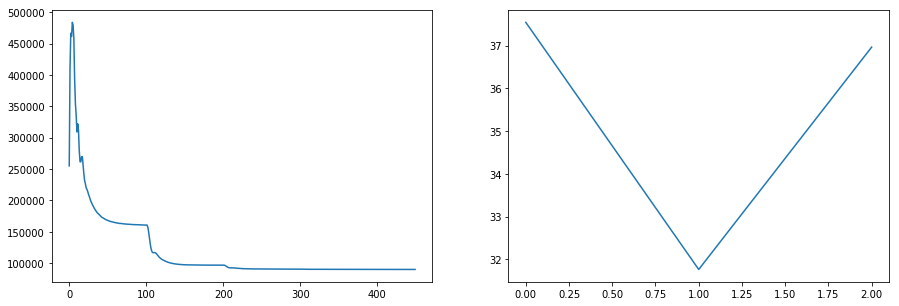

[37.54604755940869, 31.764589788670424, 36.966739962354] [0.9810567951862906, 0.964429123144773, 0.9796731016075765]


In [104]:
evf_dim = np.shape(evf_gt)
res_config = config(evf_dim = evf_dim, shape_mode = 1, init_mode = 2)
res_ph = place_holder(res_config)

hres_tensor = init_hres(res_config, lres_gt)
lres_tensor = frame_model(res_config, hres_tensor)
evf_tensor = event_model(res_config, hres_tensor)
loss = loss_pix_tv(res_config, res_ph, hres_tensor, lres_tensor, evf_tensor)

optimizer = tf.train.AdamOptimizer(learning_rate = res_ph.learning_rate, beta1 = res_config.beta1, beta2 = res_config.beta2)
opt_min = optimizer.minimize(loss)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

iloss = np.empty((res_config.epochs,))
for iepoch in range(res_config.epochs):
    if iepoch == 0:
        res_config.lr = res_config.lr_init
    hres_rec, iloss[iepoch], _ = sess.run([hres_tensor, loss, opt_min],
                               feed_dict={res_ph.lres_gt: lres_gt, 
                                          res_ph.evf_gt: evf_gt, 
                                          res_ph.learning_rate: res_config.lr})
    if iepoch % res_config.lr_update == 0:
        print("Epoch:", iepoch, "learning rate: %5f" % res_config.lr)
        if iepoch > 0:
            res_config.lr *= 0.1
print("hres_rec shape:", np.shape(hres_rec))
print("Max value %0.2f, min value %0.2f" % (np.amax(hres_rec), np.amin(hres_rec)))

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(range(res_config.epochs), iloss)
plt.subplot(122)
hres_psnr, hres_ssim = vs.computePsnrSsim(vid_gt, hres_rec)
plt.plot(range(len(hres_psnr)), hres_psnr)
plt.show()
print(hres_psnr, hres_ssim)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Frame #7')

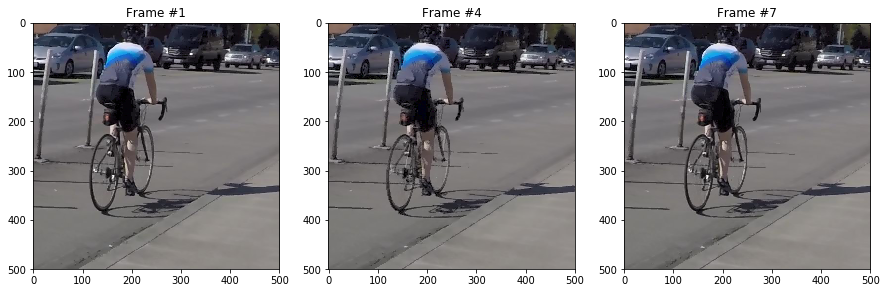

In [105]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(hres_rec[0][0])
plt.title("Frame #1")

plt.subplot(132)
plt.imshow(hres_rec[0][1])
plt.title("Frame #4")

plt.subplot(133)
plt.imshow(hres_rec[0][2])
plt.title("Frame #7")


In [106]:
savePath = 'results/mbr-interp-loss'
if not os.path.isdir(savePath):
    os.mkdir(savePath)
vidPath = os.path.join(savePath, vidList[vidId])
if not os.path.isdir(os.path.join(savePath, vidList[vidId])):
    os.mkdir(vidPath)
    
# save ground truth image
if not os.path.exists(os.path.join(vidPath, 'gt_f0.png')):
    imsave(os.path.join(vidPath, 'gt_f0.png'), vid_gt[0])
    imsave(os.path.join(vidPath, 'gt_f1.png'), vid_gt[1])
    imsave(os.path.join(vidPath, 'gt_f2.png'), vid_gt[2])
    imsave(os.path.join(vidPath, 'gt_e1.png'), (evf_gt[0]+1)*0.5)
    imsave(os.path.join(vidPath, 'gt_e2.png'), (evf_gt[1]+1)*0.5)
    
imsave(os.path.join(vidPath, 'rec_f1_tvxyt.png'), vs.imgBetween01(hres_rec[0][1]))

In [ ]:
with open(os.path.join(savePath, vidList[vidId] + '.txt'), 'a') as f:
    saveConfig = {'shape_mode': res_config.shape_mode, 'init_mode': res_config.init_mode,
                 'ev_weight': res_config.ev_weight,
                  'tanh_coef': res_config.tanh_coef, 'tv_coef_xy': res_config.tv_coef_xy,
                 'tv_coef_t': res_config.tv_coef_t, 'lr': res_config.lr_init, 'lr_update': res_config.lr_update,
                  'epochs': res_config.epochs, 'psnr': hres_psnr, 'ssim': hres_ssim}
    json.dump(saveConfig, f)